In [12]:
# Part 1 - Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE


In [2]:
# Part 2 -  Paths to the datasets, Load the datasets & Combine the datasets
file_paths = [
    'peugeot_207_01.csv',
    'peugeot_207_02.csv',
    'opel_corsa_01.csv',
    'opel_corsa_02.csv'
]

combined_df = pd.DataFrame()

for file_path in file_paths:
    # Load each dataset
    df_temp = pd.read_csv(file_path, delimiter=';')
    # Combine the datasets
    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

# Print the combined dataset to show that it has been successfully combined
print("Combined Dataset Overview:")
print(combined_df.head())  # Display the first few rows of the combined dataset
print("\nCombined Dataset Shape:", combined_df.shape)  # Display the shape of the combined dataset



Combined Dataset Overview:
   Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
0          59         -13.399994                  20.699999   
1          60         -13.200005                  17.100000   
2          61         -13.200005                  14.400000   
3          62         -11.800003                  14.400000   
4          63         -19.800003                  14.400000   

   VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
0                6.060            115.840061              -4.500000   
1                6.345            117.200816              -3.599998   
2                6.585            117.559595              -2.700001   
3                6.825            117.801222               0.000000   
4                7.065            117.925697               0.000000   

   LongitudinalAcceleration  EngineLoad  EngineCoolantTemperature  \
0                    1.0548   38.039215                      31.0   
1                    0.9012  

In [3]:
# Part 3 - Clean the dataset and Encode the 'traffic' column using LabelEncoder and Display the first few rows of the cleaned dataset and the encoding

# Drop rows with missing values
combined_df_cleaned = combined_df.dropna().copy()

# Encode the 'traffic' column
le = LabelEncoder()
combined_df_cleaned['traffic_encoded'] = le.fit_transform(combined_df_cleaned['traffic'])

# Select features and target variable
features = combined_df_cleaned.columns.drop(['Unnamed: 0', 'traffic', 'traffic_encoded', 'drivingStyle', 'roadSurface'])
X_combined = combined_df_cleaned[features]
y_combined = combined_df_cleaned['traffic_encoded']

# Ensure all feature columns are numeric
numeric_cols = features.tolist()  # Assuming 'features' contains only numeric columns
combined_df_cleaned[numeric_cols] = combined_df_cleaned[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Calculate correlations among numeric features only
corr = combined_df_cleaned[numeric_cols].corr()


# Display the first few rows of the cleaned dataset and the encoding
combined_df_cleaned[['traffic', 'traffic_encoded']].head(), le.classes_


(                  traffic  traffic_encoded
 0  LowCongestionCondition                1
 1  LowCongestionCondition                1
 2  LowCongestionCondition                1
 3  LowCongestionCondition                1
 4  LowCongestionCondition                1,
 array(['HighCongestionCondition', 'LowCongestionCondition',
        'NormalCongestionCondition'], dtype=object))

In [4]:

# Part 4- Split the dataset into training and testing sets, Apply feature scaling and Balance the dataset using SMOTE
# Apply feature scaling
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_combined_scaled, y_combined)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.1, random_state=42)

# Display the shapes of the training and testing sets to confirm the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47943, 14), (5328, 14), (47943,), (5328,))

In [5]:
# Part 5 - Initialize and train the three models, Make predictions and evaluate the model with cross-validation
logistic_model = LogisticRegression(max_iter=1000)
svm_model = SVC()
knn_model = KNeighborsClassifier()

models = {'Logistic Regression': logistic_model, 'SVM': svm_model, 'kNN': knn_model}
for name, model in models.items():
    # Apply cross-validation
    cv_scores = cross_val_score(model, X_balanced, y_balanced, cv=5)
    print(f"{name} Cross-Validation Accuracy: {cv_scores.mean()}")


Logistic Regression Cross-Validation Accuracy: 0.6054153032676561
SVM Cross-Validation Accuracy: 0.8883452871988912
kNN Cross-Validation Accuracy: 0.8964544170251916


In [7]:
# More detailed evaluation metrics for each model on the test set using classification_report
# Initialize models
logistic_model = LogisticRegression(max_iter=1000)
svm_model = SVC()
knn_model = KNeighborsClassifier()

models = {
    'Logistic Regression': logistic_model,
    'SVM': svm_model,
    'kNN': knn_model
}

# Dictionary to hold evaluation metrics for each model
model_evaluation_metrics = {}

# Train each model, predict, and calculate metrics
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store metrics for each model
    model_evaluation_metrics[name] = report

# Display the evaluation metrics for each model
for model_name, metrics in model_evaluation_metrics.items():
    print(f"Model: {model_name}")
    print("Precision, Recall, F1-Score for each class:")
    for key, value in metrics.items():
        if key.isdigit():  # Check if the key represents a class
            print(f"Class {key}: Precision: {value['precision']:.2f}, Recall: {value['recall']:.2f}, F1-Score: {value['f1-score']:.2f}")
    print("-" * 80)

Model: Logistic Regression
Precision, Recall, F1-Score for each class:
Class 0: Precision: 0.66, Recall: 0.78, F1-Score: 0.72
Class 1: Precision: 0.67, Recall: 0.61, F1-Score: 0.64
Class 2: Precision: 0.58, Recall: 0.53, F1-Score: 0.56
--------------------------------------------------------------------------------
Model: SVM
Precision, Recall, F1-Score for each class:
Class 0: Precision: 0.93, Recall: 0.99, F1-Score: 0.96
Class 1: Precision: 0.97, Recall: 0.89, F1-Score: 0.93
Class 2: Precision: 0.94, Recall: 0.96, F1-Score: 0.95
--------------------------------------------------------------------------------
Model: kNN
Precision, Recall, F1-Score for each class:
Class 0: Precision: 0.97, Recall: 1.00, F1-Score: 0.98
Class 1: Precision: 1.00, Recall: 0.93, F1-Score: 0.96
Class 2: Precision: 0.96, Recall: 1.00, F1-Score: 0.98
--------------------------------------------------------------------------------


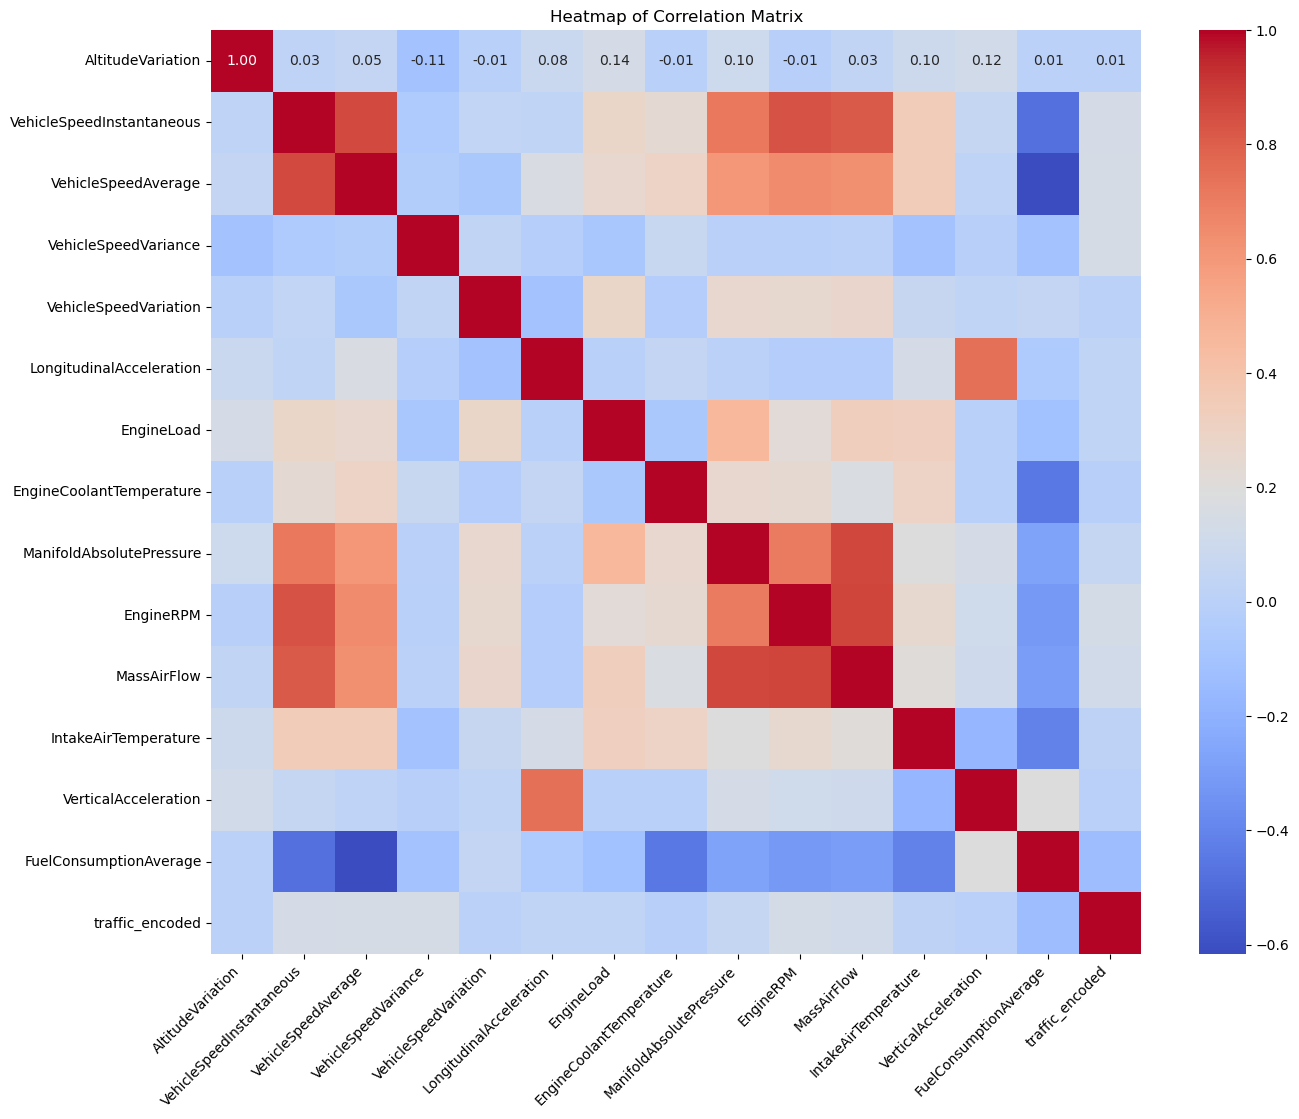

In [29]:
# Part 6 - Heatmap of Correlations Visualizations

# Set the figure size to ensure it's large enough to show all details
plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()
